In [1]:
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [3]:
comp_dir = Path('store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_13776/908750039.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(
/var/folders/j0/tqzlnmks6cx221q8pl95104w0000gn/T/ipykernel_13776/908750039.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['family', 'date'])


In [4]:
store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

In [5]:
family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055664  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259277  0.000000   
2017-08-13   8.907408  0.166667   8.018518  3747.296387  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629639  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462891  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305298   16.111111  1031.148193   831.648132  345.934967   
2017-08-12   507.473114   15.722222  1072.870361   793.592590  290.553558   
2017-08-13   615.976990   10.074074  1143.648193   928.000000  325.801361   
2017-08-14   518.564026   11.000000  1019.111084   797.222229  271.532257   
2017-08-15   539.966553   11.055555  1082.851807   753.833313  276.582458   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize Supply Sales. We'll store the result in a variable y_deseason.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


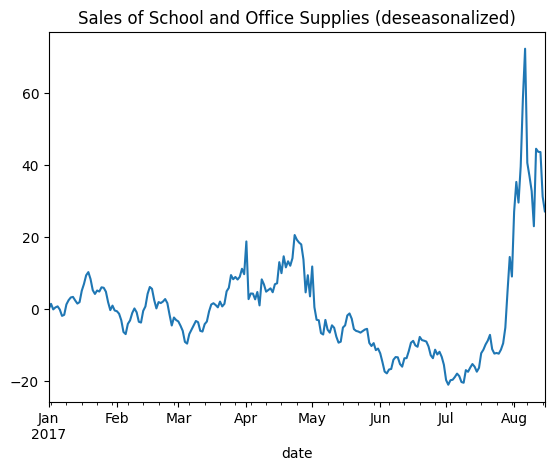

In [6]:
# showing fluctuations not explained by regular seasonality or New Year's Day

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Text(0.5, 1.0, 'Seven-Day Moving Average')

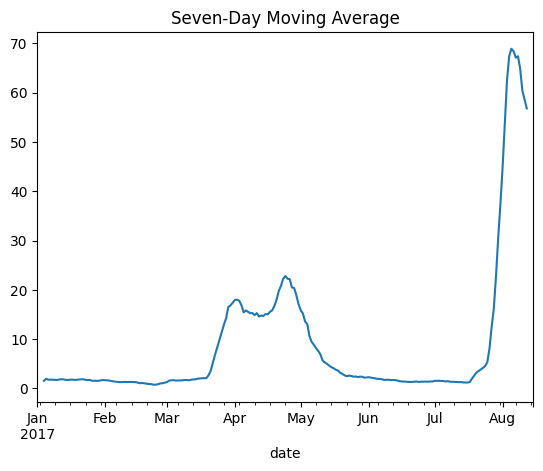

In [7]:
# we can try to isolate cyclic behavior using a moving-average plot 
# just like we did with trend. The idea is to choose a window long enough 
# to smooth over short-term seasonality, but short enough to still preserve
#  the cycles. Now, we create a seven-day moving average from y, the series
#  of supply sales

y_ma = y.rolling(7, center=True).mean()
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average")

In [15]:
# https://github.com/Kaggle/learntools/blob/master/learntools/time_series/utils.py

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

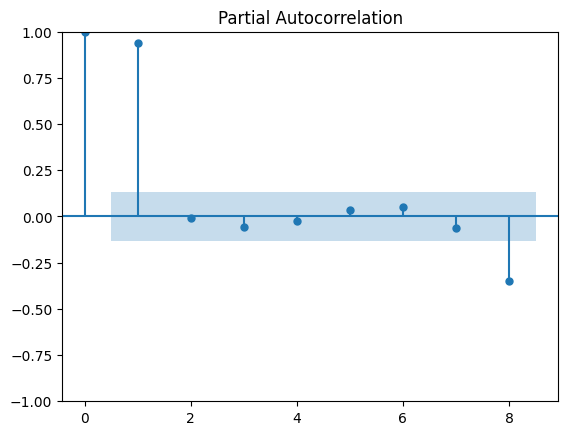

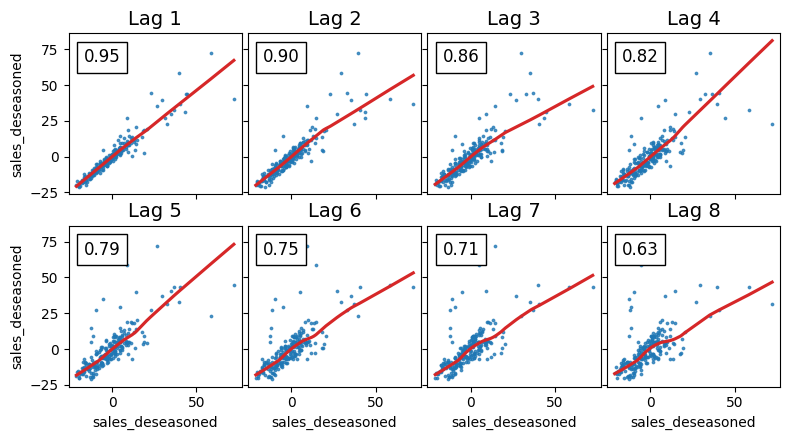

In [9]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

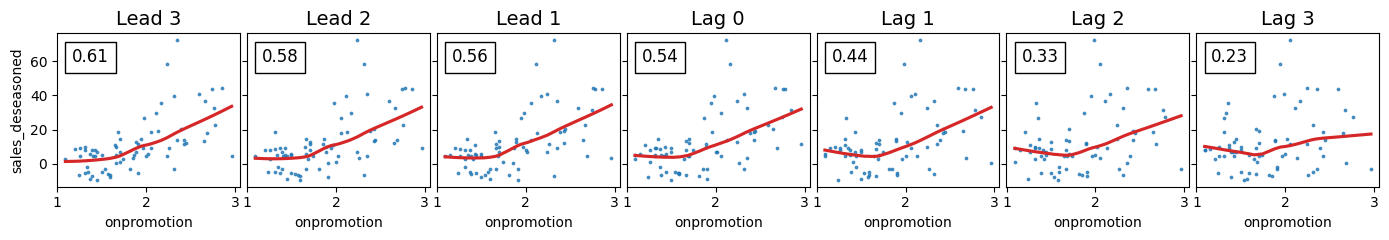

In [12]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

In [16]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

<Axes: xlabel='date'>

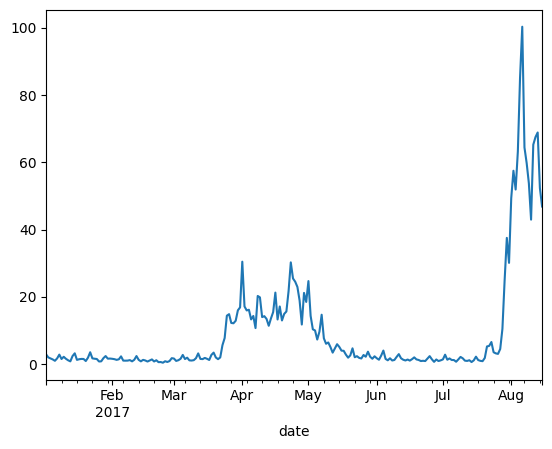

In [20]:
y.plot()

Training RMSLE: 0.23893
Validation RMSLE: 0.34245


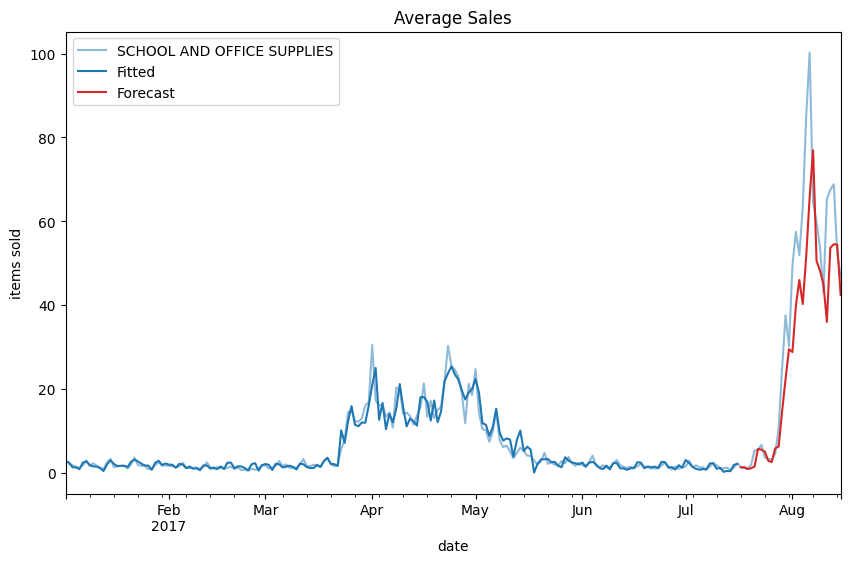

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(figsize=(10, 6), grid=True, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

In [ ]:
# We can create more statistical features:

# https://pandas.pydata.org/pandas-docs/stable/reference/window.html

y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

mean_7 = y_lag.rolling(7).mean()
median_14 = y_lag.rolling(14).median()
std_7 = y_lag.rolling(7).std()
promo_7 = onpromo.rolling(7, center=True).sum()